In [1]:
import argparse
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torchvision
import torchvision.models as models
import datetime
import sys
import sklearn
from torch.autograd import Function
import torch.nn.functional as F
from sklearn.metrics import f1_score
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets

In [2]:
batch_size = 16
input_size = (256, 128)
aspect_ratio = [2, 1]
is_vit = False
if(torch.cuda.is_available()):
  device=torch.device('cuda')
  print("GPU")
else:
  device=torch.device('cpu')
  print('CPU')

GPU


In [3]:
def resize_image_with_aspect(image):
    w, h = image.size
    cut_h = h - aspect_ratio[1] * w / aspect_ratio[0]
    image = image.crop((0, cut_h / 2, w, h-(cut_h/2)))
    image = image.resize(input_size)
    return image

In [4]:
def calc_coeff(iter_num, high=1.0, low=0.0, alpha=10.0, max_iter=10000.0):
    return float(2.0 * (high - low) / (1.0 + np.exp(-alpha * iter_num / max_iter)) - (high - low) + low)

In [5]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        # nn.init.zeros_(m.bias)
        m.bias.data.fill_(0)

In [6]:
def Entropy(input_):
    epsilon = 1e-5
    entropy = -input_ * torch.log(input_ + epsilon)
    entropy = torch.sum(entropy, dim=1)
    return entropy


def grl_hook(coeff):
    def fun1(grad):
        return -coeff * grad.clone()

    return fun1


def CDAN(input_list, ad_net, entropy=None, coeff=None, random_layer=None):
    softmax_output = input_list[1].detach()
    feature = input_list[0]
    if random_layer is None:
        op_out = torch.bmm(softmax_output.unsqueeze(2), feature.unsqueeze(1))
        ad_out = ad_net(op_out.view(-1, softmax_output.size(1) * feature.size(1)))
    else:
        random_out = random_layer.forward([feature, softmax_output])
        ad_out = ad_net(random_out.view(-1, random_out.size(1)))
    batch_size = softmax_output.size(0) // 2
    dc_target = torch.from_numpy(np.array([[1]] * batch_size + [[0]] * batch_size)).float()
    dc_target = dc_target.cuda()
    if entropy is not None:
        entropy.register_hook(grl_hook(coeff))
        entropy = 1.0 + torch.exp(-entropy)
        source_mask = torch.ones_like(entropy)
        source_mask[feature.size(0) // 2:] = 0
        source_weight = entropy * source_mask
        target_mask = torch.ones_like(entropy)
        target_mask[0:feature.size(0) // 2] = 0
        target_weight = entropy * target_mask
        weight = source_weight / torch.sum(source_weight).detach().item() + \
                 target_weight / torch.sum(target_weight).detach().item()
        l = nn.BCELoss(reduction='none')(ad_out, dc_target)
        return torch.sum(weight.view(-1, 1) * nn.BCELoss()(ad_out, dc_target)) / torch.sum(weight).detach().item()
    else:
        return nn.BCELoss()(ad_out, dc_target)


def mdd_loss(features, labels, left_weight=1, right_weight=1):
    softmax_out = nn.Softmax(dim=1)(features)
    batch_size = features.size(0)
    if float(batch_size) % 2 != 0:
        raise Exception('Incorrect batch size provided')

    batch_left = softmax_out[:int(0.5 * batch_size)]
    batch_right = softmax_out[int(0.5 * batch_size):]

    loss = torch.norm((batch_left - batch_right).abs(), 2, 1).sum() / float(batch_size)

    labels_left = labels[:int(0.5 * batch_size)]
    batch_left_loss = get_pari_loss1(labels_left, batch_left)

    labels_right = labels[int(0.5 * batch_size):]
    batch_right_loss = get_pari_loss1(labels_right, batch_right)
    return loss + left_weight * batch_left_loss + right_weight * batch_right_loss


def mdd_digit(features, labels, left_weight=1, right_weight=1, weight=1):
    softmax_out = nn.Softmax(dim=1)(features)
    batch_size = features.size(0)
    if float(batch_size) % 2 != 0:
        raise Exception('Incorrect batch size provided')

    batch_left = softmax_out[:int(0.5 * batch_size)]
    batch_right = softmax_out[int(0.5 * batch_size):]

    loss = torch.norm((batch_left - batch_right).abs(), 2, 1).sum() / float(batch_size)

    labels_left = labels[:int(0.5 * batch_size)]
    labels_left_left = labels_left[:int(0.25 * batch_size)]
    labels_left_right = labels_left[int(0.25 * batch_size):]

    batch_left_left = batch_left[:int(0.25 * batch_size)]
    batch_left_right = batch_left[int(0.25 * batch_size):]
    batch_left_loss = get_pair_loss(labels_left_left, labels_left_right, batch_left_left, batch_left_right)

    labels_right = labels[int(0.5 * batch_size):]
    labels_right_left = labels_right[:int(0.25 * batch_size)]
    labels_right_right = labels_right[int(0.25 * batch_size):]

    batch_right_left = batch_right[:int(0.25 * batch_size)]
    batch_right_right = batch_right[int(0.25 * batch_size):]
    batch_right_loss = get_pair_loss(labels_right_left, labels_right_right, batch_right_left, batch_right_right)

    return weight*loss + left_weight * batch_left_loss + right_weight * batch_right_loss

def get_pair_loss(labels_left, labels_right, features_left, features_right):
    loss = 0
    for i in range(len(labels_left)):
        if (labels_left[i] == labels_right[i]):
            loss += torch.norm((features_left[i] - features_right[i]).abs(), 2, 0).sum()
    return loss

def get_pari_loss1(labels, features):
    loss = 0
    count = 0
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if (labels[i] == labels[j]):
                count += 1
                loss += torch.norm((features[i] - features[j]).abs(), 2, 0).sum()
    return loss / count

In [7]:
def DANN(features, ad_net):
    ad_out = ad_net(features)
    batch_size = ad_out.size(0) // 2
    dc_target = torch.from_numpy(np.array([[1]] * batch_size + [[0]] * batch_size)).float().cuda()
    return nn.BCELoss()(ad_out, dc_target)

In [8]:
def compute_kl_divergence_loss(source_features, target_features):
    # Apply softmax along the channel dimension to convert features into probabilities
    source_probs = F.softmax(source_features, dim=1)
    target_probs = F.softmax(target_features, dim=1)

    # Calculate KL divergence
    kl_loss = F.kl_div(target_probs.log(), source_probs, reduction='batchmean')
    
    return kl_loss

In [9]:
def compute_covariance_loss(source_features, target_features):
    # Flatten the feature maps
    source_flat = source_features.view(source_features.size(0), -1)
    target_flat = target_features.view(target_features.size(0), -1)

    # Calculate mean-centered feature maps
    source_mean = torch.mean(source_flat, dim=1, keepdim=True)
    target_mean = torch.mean(target_flat, dim=1, keepdim=True)

    source_centered = source_flat - source_mean
    target_centered = target_flat - target_mean

    # Calculate covariance matrices
    source_covariance = torch.matmul(source_centered, source_centered.t()) / source_flat.size(1)
    target_covariance = torch.matmul(target_centered, target_centered.t()) / target_flat.size(1)

    # Calculate Frobenius norm of the difference between covariance matrices
    cov_loss = torch.norm(source_covariance - target_covariance, p='fro')

    return cov_loss


In [10]:
def compute_mmd(source_features, target_features, sigma=1.0):
    def gaussian_kernel(x, y):
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
        distance = (x - y).pow(2).sum(dim=2)
        return torch.exp(-distance / (2 * sigma ** 2))

    source_kernel = gaussian_kernel(source_features, source_features)
    target_kernel = gaussian_kernel(target_features, target_features)
    cross_kernel = gaussian_kernel(source_features, target_features)
    mmd_loss = source_kernel.mean() + target_kernel.mean() - 2 * cross_kernel.mean()
    
    return mmd_loss

In [11]:
def compute_tsne_loss(source_features, target_features, perplexity=30.0):

    def tsne(embeddings, perplexity):
        # tsne_model = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_embeddings = TSNE().fit_transform(embeddings.cpu().detach().numpy())
        return torch.FloatTensor(tsne_embeddings).to(embeddings.device)

    source_tsne = tsne(source_features, perplexity)
    target_tsne = tsne(target_features, perplexity)
    

    distance_loss = F.mse_loss(source_tsne, target_tsne)

    return distance_loss * 0.001

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.43335001, 0.43360192, 0.42602362), (0.28486016, 0.28320433, 0.28699529)),
])
flipTransform = transforms.RandomHorizontalFlip(p=1)
zoomTransform = transforms.RandomResizedCrop(input_size[:: -1], scale=(0.7, 1))
colorTransform = transforms.ColorJitter(brightness=(0.65, 0.9), contrast=(1.1, 1.35))

In [13]:
def generate_batches(df, train=True, validation=False):
    if train:
        labels = df['has_under_extrusion'].tolist()
    printers = df['printer_id'].unique().tolist()
    printer_domain_map = {printer_id: idx for idx, printer_id in enumerate(printers)}
    domains = [printer_domain_map[domain] for domain in df['printer_id'].tolist()]
    prints = df['print_id'].unique().tolist()
    print_domain_map = {print_id: idx for idx, print_id in enumerate(prints)}
    print_jobs = [print_domain_map[print] for print in df['print_id'].tolist()]
        
    image_paths = df['img_path'].tolist()
    current = 0
    while current < len(df):
        batch_images, batch_domains, batch_labels, batch_paths, batch_prints = [], [], [], [], []
        batch_idx = 0
        reserve_images, reserve_domains, reserve_labels, reserve_prints = [], [], [], []
        
        while batch_idx < batch_size:
            if current + batch_idx >= len(df):
                break
            
            image_path = image_paths[current + batch_idx]
            domain = domains[current + batch_idx]
            print_job = print_jobs[current + batch_idx]
            image_path = image_path.split('/')[-1]
            filename = '/home/shravandinakaran/data/'+image_path
            image = Image.open(filename)
            if is_vit:
                image = resize_to_square(image)
            else:
                image = resize_image_with_aspect(image)
            if train:
                label = labels[current + batch_idx]
                batch_labels.append(label)
            batch_domains.append(domain)
            batch_prints.append(print_job)
            batch_images.append(transform(image))
            batch_paths.append(image_path)
            batch_idx += 1
        current += batch_size
        if train:
            yield batch_images, np.array(batch_labels), np.array(batch_domains), np.array(batch_prints)
        else:
            yield batch_images, batch_paths

In [14]:
source_df = pd.read_csv('/home/shravandinakaran/data/source.csv')
target_df = pd.read_csv('/home/shravandinakaran/data/target.csv')
print(len(source_df), len(target_df))

29248 28287


In [15]:

source_df = source_df.loc[source_df['printer_id'].isin([102])]
print(len(source_df), len(target_df))

22408 28287


In [16]:

class AdversarialNetwork(nn.Module):
    def __init__(self, in_feature, hidden_size):
        super(AdversarialNetwork, self).__init__()
        self.ad_layer1 = nn.Linear(in_feature, hidden_size)
        self.ad_layer2 = nn.Linear(hidden_size, hidden_size)
        self.ad_layer3 = nn.Linear(hidden_size, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.apply(init_weights)
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = 10000.0

    def forward(self, x):
        if self.training:
            self.iter_num += 1
        coeff = calc_coeff(self.iter_num, self.high, self.low, self.alpha, self.max_iter)
        x = x * 1.0
        x.register_hook(grl_hook(coeff))
        x = self.ad_layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.ad_layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        y = self.ad_layer3(x)
        y = self.sigmoid(y)
        return y

    def output_num(self):
        return 1

    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 10, 'decay_mult': 2}]

In [25]:
class ResNetFc(nn.Module):
    def __init__(self, use_bottleneck=True, bottleneck_dim=256, new_cls=True, class_num=2):
        super(ResNetFc, self).__init__()
        model_resnet = models.resnet50(pretrained=True)
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.feature_layers = nn.Sequential(self.conv1, self.bn1, self.relu, self.maxpool, \
                             self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool)

        self.use_bottleneck = use_bottleneck
        self.new_cls = new_cls
        if new_cls:
            if self.use_bottleneck:
                self.bottleneck = nn.Linear(model_resnet.fc.in_features, bottleneck_dim)
                self.fc = nn.Linear(bottleneck_dim, 2)
                self.bottleneck.apply(init_weights)
                self.fc.apply(init_weights)
                self.__in_features = bottleneck_dim
            else:
                self.fc = nn.Linear(model_resnet.fc.in_features, 2)
                self.fc.apply(init_weights)
                self.__in_features = model_resnet.fc.in_features
        else:
            self.fc = model_resnet.fc
            self.__in_features = model_resnet.fc.in_features

    def forward(self, x):
        x = self.feature_layers(x)
        x = x.view(x.size(0), -1)
        if self.use_bottleneck and self.new_cls:
            x = self.bottleneck(x)
        y = self.fc(x)
        return x, y

    def output_num(self):
        return self.__in_features

    def get_parameters(self):
        if self.new_cls:
            if self.use_bottleneck:
                parameter_list = [{"params":self.feature_layers.parameters(), "lr_mult":1, 'decay_mult':2}, \
                                {"params":self.bottleneck.parameters(), "lr_mult":10, 'decay_mult':2}, \
                                {"params":self.fc.parameters(), "lr_mult":10, 'decay_mult':2}]
            else:
                parameter_list = [{"params":self.feature_layers.parameters(), "lr_mult":1, 'decay_mult':2}, \
                                {"params":self.fc.parameters(), "lr_mult":10, 'decay_mult':2}]
        else:
            parameter_list = [{"params":self.parameters(), "lr_mult":1, 'decay_mult':2}]
        return parameter_list

In [26]:
def image_classification_test(model, test_10crop=True):
    start_test = True
    
    target_generator = generate_batches(target_test_df)
    len_train_target = len(target_test_df) // batch_size
    with torch.no_grad():
        for i in range(len_train_target):
            inputs, labels, _, _ = next(target_generator)
            inputs = torch.stack(inputs, dim=0, out=None).to(device)
            labels = torch.from_numpy(labels).to(device)
            
            _, outputs = model(inputs)
            if start_test:
                all_output = outputs.float().cpu()
                all_label = labels.float().cpu()
                start_test = False
            else:
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float().cpu()), 0)
            
    _, predict = torch.max(all_output, 1)
    all_label = all_label.cpu()
    accuracy = torch.sum(torch.squeeze(predict).float() == all_label).item() / float(all_label.size()[0])
    return accuracy

In [27]:
class_num = 2
random = False
method = 'CDAN+E'
trade_off = 1.0
 
base_network = ResNetFc()
base_network = base_network.cuda()

if random:
    random_layer = network.RandomLayer([base_network.output_num(), class_num], 1024)
    ad_net = AdversarialNetwork(1024, 1024)
    random_layer.cuda()
else:
    random_layer = None
    ad_net = AdversarialNetwork(base_network.output_num() * class_num, 1024)
ad_net = ad_net.cuda()
parameter_list = base_network.get_parameters() + ad_net.get_parameters()

## set optimizer
optimizer = optim.SGD(base_network.parameters(), lr=0.001, weight_decay=0.0005, momentum=0.9)
optimizer_ad = optim.SGD(ad_net.parameters(), lr=0.001, weight_decay=0.0005, momentum=0.9)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
source_df = source_df.loc[source_df['printer_id'].isin([102])]
print(len(source_df), len(target_df))
source_df = source_df.sample(frac=1).reset_index(drop=True)
target_df = target_df.sample(frac=1).reset_index(drop=True)
target_train_df = target_df.iloc[:int(0.8*len(target_df))]
target_test_df = target_df.iloc[int(0.8*len(target_df)):]  
source_df = source_df.iloc[:int(0.8*len(source_df))]
other_df = source_df.iloc[int(0.8*len(source_df)):]  
target_test_df = pd.concat([target_test_df, other_df])
print(len(target_df), len(target_train_df), len(target_test_df), len(source_df))

28287 22629 9244 17926


In [ ]:
source_df = source_df.loc[source_df['printer_id'].isin([102])]
source_df = source_df.sample(frac=1).reset_index(drop=True)
target_df = target_df.sample(frac=1).reset_index(drop=True)

temp_df = source_df
source_df = target_df
target_train_df = temp_df.iloc[:int(0.8*len(temp_df))]
target_test_df = temp_df.iloc[int(0.8*len(temp_df)):]  


print(len(target_df), len(target_train_df), len(target_test_df), len(source_df))

In [29]:
source_generator = generate_batches(source_df)
target_generator = generate_batches(target_train_df)

len_dataloader = min(len(source_df) // batch_size, len(target_train_df) // batch_size)

transfer_loss_value = classifier_loss_value = total_loss_value = 0.0
best_acc = 0.0

source_loss, target_loss, cross_loss = [], [], []
for i in tqdm(range(len_dataloader)):
    if i % 200 == 0 and i > 0:
        base_network.train(False)
        temp_acc = image_classification_test(base_network)
        if temp_acc > best_acc:
            best_acc = temp_acc
            best_model = base_network
        log_str = "iter: {:05d}, precision: {:.5f}".format(i, temp_acc)
        print(log_str)

    base_network.train(True)
    ad_net.train(True)
    # optimizer = lr_scheduler(optimizer, i, **schedule_param)
    optimizer.zero_grad()
    optimizer_ad.zero_grad()
    
    inputs_source, labels_source, _, _ = next(source_generator)
    inputs_target, labels_target, _, _ = next(target_generator)
    
    inputs_source = torch.stack(inputs_source, dim=0, out=None).to(device)
    labels_source = torch.from_numpy(labels_source).to(device)
    
    inputs_target = torch.stack(inputs_target, dim=0, out=None).to(device)
    labels_target = torch.from_numpy(labels_target).to(device)
    
    features_source, outputs_source = base_network(inputs_source)
    features_target, outputs_target = base_network(inputs_target)
    
    features = torch.cat((features_source, features_target), dim=0)
    outputs = torch.cat((outputs_source, outputs_target), dim=0)
    labels = torch.cat((labels_source, labels_target))
    softmax_out = nn.Softmax(dim=1)(outputs)
    
    if method == 'CDAN+E':           
        entropy = Entropy(softmax_out)
        transfer_loss = CDAN([features, softmax_out], ad_net, entropy, calc_coeff(i), random_layer)
    elif method  == 'CDAN':
        transfer_loss = CDAN([features, softmax_out], ad_net, None, None, random_layer)
    elif method  == 'DANN':
        transfer_loss = DANN(features, ad_net)

    classifier_loss = nn.CrossEntropyLoss()(outputs_source, labels_source)
    total_loss = trade_off * transfer_loss + classifier_loss + mdd_loss(features, labels)
    total_loss.backward()
    optimizer.step()
    optimizer_ad.step()

 18%|█▊        | 200/1120 [03:39<17:35,  1.15s/it]

iter: 00200, precision: 0.70776


 36%|███▌      | 400/1120 [11:34<13:20,  1.11s/it]   

iter: 00400, precision: 0.63107


 54%|█████▎    | 600/1120 [17:27<09:08,  1.05s/it]  

iter: 00600, precision: 0.62998


 71%|███████▏  | 800/1120 [23:15<05:45,  1.08s/it]  

iter: 00800, precision: 0.63020


 89%|████████▉ | 1000/1120 [30:31<03:39,  1.83s/it] 


KeyboardInterrupt: 

In [99]:
best_acc

0.5194575471698113

In [105]:
temp_acc = image_classification_test(base_network)

In [106]:
from tqdm import tqdm

In [ ]:
#same = 0.1770, 0.1726
#same = 1.3797, 1.3205
#same = 2, 2

In [21]:
from sklearn.manifold import TSNE
source_generator = generate_batches(source_df)
target_generator = generate_batches(target_train_df)
base_network.eval()

i = 0
features_svhn, features_mnist = [], []
printers_s, printers_t = [], []
while i < 70:
    data_source = next(source_generator)
    img, label, printer, _ = data_source
    img = torch.stack(img, dim=0, out=None).to(device)
    features_source, _ = base_network(img)
    features_svhn.extend(features_source.detach().cpu().numpy())
    printers_s.extend(printer)
    
    data_source = next(target_generator)
    img, label, printer, _ = data_source
    img = torch.stack(img, dim=0, out=None).to(device)
    features_target, _ = base_network(img)
    features_mnist.extend(features_target.detach().cpu().numpy())
    printers_t.extend(printer)
    
    i += 1

In [22]:
features_svhn = np.array(features_svhn)
features_mnist = np.array(features_mnist)
printers_s = np.array(printers_s)
printers_t = np.array(printers_s)
printers_s

array([0, 0, 0, ..., 0, 0, 0])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with lo

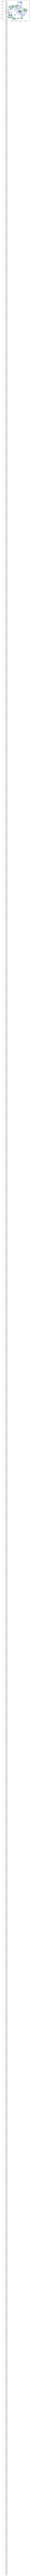

In [23]:
colors = {0: 'b', 1: 'r', 2: 'g', 3: 'y'}
tsne_svhn = TSNE().fit_transform(features_svhn)
tsne_mnist = TSNE().fit_transform(features_mnist)
for i in range(len(printers_s)):    
    plt.scatter(tsne_svhn[i:, 0], tsne_svhn[i:, 1], color=colors[printers_s[i]], s=1)
    plt.scatter(tsne_mnist[i:, 0], tsne_mnist[i:, 1], color=colors[2+printers_t[i]], s=1)
    plt.legend()